<a href="https://colab.research.google.com/github/snufkin92/colab_tutorial/blob/master/section_08/simple_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# シンプルなLSTMの実装
LSTM層を用いてシンプルなニューラルネットワークを構築し、時系列データを学習します。  
今回は、通常のRNNとLSTMを比較します。

## 訓練用データの作成
訓練用のデータを作成します。  
サイン関数に乱数でノイズを加えたデータを作成し、過去の時系列データから未来の値を予測できるようにします。  
RNNの場合と同様に、正解は入力の時系列を一つ後にずらしたものにします。

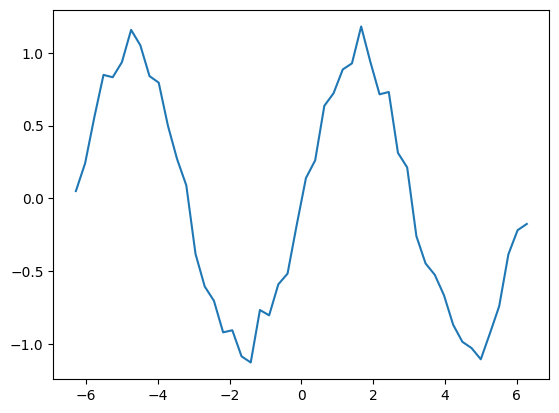

(40, 10, 1)
(40, 10, 1)
[[0.04967142]
 [0.23982815]
 [0.55548641]
 [0.84798554]
 [0.83172743]
 [0.93525416]
 [1.1574075 ]
 [1.05167139]
 [0.83965187]
 [0.794534  ]]
値が１つだけずれているのが分かる。こういう時系列データが40個
[[0.23982815]
 [0.55548641]
 [0.84798554]
 [0.83172743]
 [0.93525416]
 [1.1574075 ]
 [1.05167139]
 [0.83965187]
 [0.794534  ]
 [0.49919313]]


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# simple_rnn.ipynbと同じ時系列データ
x_data = np.linspace(-2*np.pi, 2*np.pi)  # -2πから2πまで

np.random.seed(42)  # 乱数のシードを固定
sin_data = np.sin(x_data) + 0.1*np.random.randn(len(x_data))  # sin関数に乱数でノイズを加える

plt.plot(x_data, sin_data)
plt.show()

n_rnn = 10  # 時系列の数
n_sample = len(x_data)-n_rnn  # サンプル数
x = np.zeros((n_sample, n_rnn))  # 入力
t = np.zeros((n_sample, n_rnn))  # 正解
for i in range(0, n_sample):
    x[i] = sin_data[i:i+n_rnn]
    t[i] = sin_data[i+1:i+n_rnn+1]  # 時系列を入力よりも一つ後にずらす

x = x.reshape(n_sample, n_rnn, 1)  # サンプル数、時系列の数、入力層のニューロン数
print(x.shape)
t = t.reshape(n_sample, n_rnn, 1)  # 今回は入力と同じ形状
print(t.shape)

print(x[0])
print("値が１つだけずれているのが分かる。こういう時系列データが40個")
print(x[1])

## SimpleRNNとLSTMの比較
Kerasを使って通常のRNN、およびLSTMを構築します。  
Kerasにおいて、LSTM層はSimpleRNN層と同じ方法で追加することができます。

In [3]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

batch_size = 8  # バッチサイズ
n_in = 1  # 入力層のニューロン数
n_mid = 20  # 中間層のニューロン数
n_out = 1  # 出力層のニューロン数

# 比較のための通常のRNN
model_rnn = Sequential()
model_rnn.add(SimpleRNN(n_mid, input_shape=(n_rnn, n_in), return_sequences=True))
model_rnn.add(Dense(n_out, activation="linear"))
model_rnn.compile(loss="mean_squared_error", optimizer="sgd")
print(model_rnn.summary())

# LSTM
model_lstm = Sequential()

# 違うのはSimpleRNNではなくLSTM に変えているだけ（学習パラメータがほぼ4倍）
model_lstm.add(LSTM(n_mid, input_shape=(n_rnn, n_in), return_sequences=True))
model_lstm.add(Dense(n_out, activation="linear"))
model_lstm.compile(loss="mean_squared_error", optimizer="sgd")
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 20)            440       
                                                                 
 dense (Dense)               (None, 10, 1)             21        
                                                                 
Total params: 461 (1.80 KB)
Trainable params: 461 (1.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 20)            1760      
                                                                 
 dense_1 (Dense)             (None, 10, 1)             21        
                                                                 

### summaryについて

> lstm (LSTM)   (None, 10, 20)       

None:バッチサイズ。可変であることを表す（ネットワークだのサマリーであって学習ではないのでNone）

10：時系列の数（入力の要素数）＝各タイムステップを表現する中間層の数に相当

20：各タイムステップ（次のタイムステップの値を予想する中間層に相当）の出力ノード数

SimpleRNNよりも、LSTMの方がパラメータがずっと多いですね。

## 学習
構築したモデルを使って、学習を行います。  

In [4]:
import time

epochs = 1000

# 通常のRNN
start_time = time.time()
history_rnn = model_rnn.fit(x, t, epochs=epochs, batch_size=batch_size, verbose=0)
print("学習時間 --通常のRNN--:", time.time() - start_time)

# LSTM
start_time = time.time()
history_lstm = model_lstm.fit(x, t, epochs=epochs, batch_size=batch_size, verbose=0)
print("学習時間 --LSTM--:", time.time() - start_time)

学習時間 --通常のRNN--: 18.101902961730957
学習時間 --LSTM--: 43.364747047424316


エポック数が同じ場合、パラメータ数が多いためLSTMの方が学習にずっと時間がかかります。

## 学習の推移
誤差の推移を確認します。

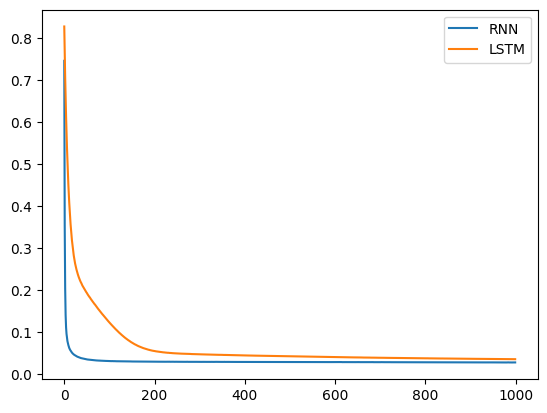

In [5]:
loss_rnn = history_rnn.history['loss']
loss_lstm = history_lstm.history['loss']

plt.plot(np.arange(len(loss_rnn)), loss_rnn, label="RNN")
plt.plot(np.arange(len(loss_lstm)), loss_lstm, label="LSTM")
plt.legend()
plt.show()

モデルが複雑なため、LSTMの方が誤差の収束にエポック数が必要です。

## 学習済みモデルの使用
それぞれの学習済みモデルを使って、サイン関数の次の値を予測します。

1/1 [==============================] - 0s 24ms/step


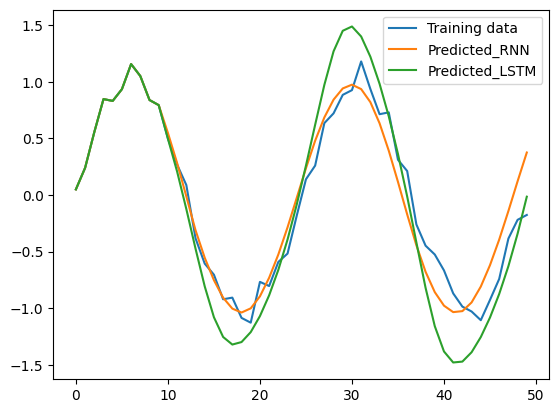

In [6]:
predicted_rnn = x[0].reshape(-1)
predicted_lstm = x[0].reshape(-1)

for i in range(0, n_sample):
    y_rnn = model_rnn.predict(predicted_rnn[-n_rnn:].reshape(1, n_rnn, 1))
    predicted_rnn = np.append(predicted_rnn, y_rnn[0][n_rnn-1][0])
    y_lstm = model_lstm.predict(predicted_lstm[-n_rnn:].reshape(1, n_rnn, 1))
    predicted_lstm = np.append(predicted_lstm, y_lstm[0][n_rnn-1][0])

plt.plot(np.arange(len(sin_data)), sin_data, label="Training data")
plt.plot(np.arange(len(predicted_rnn)), predicted_rnn, label="Predicted_RNN")
plt.plot(np.arange(len(predicted_lstm)), predicted_lstm, label="Predicted_LSTM")
plt.legend()
plt.show()

LSTMを使ったモデルが、サインカーブを学習できていることが分かります。  

このように、LSTMはRNNと同様に時系列データの学習ができるのですが、パラメータ数が多くモデルが複雑なため学習に時間がかかります。  
今回の例からはLSTMのメリットはあまり分かりませんが、文脈が大事な自然言語処理などで、LSTMはその真価を発揮します。